In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import keras
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

#### Load Preprocessing

In [3]:
%run utils.py

#### Load Models

In [61]:
%run models.py
%run cam.py

#### Preprocessing

In [5]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
CPU times: user 21.4 s, sys: 2.48 s, total: 23.8 sing 75/117Interpolating 98/117Interpolating 117/117Interpolating 1/112Interpolating 58/112Interpolating 109/112Interpolating 1/111Interpolating 54/111Interpolating 101/111Interpolating 1/109Interpolating 58/109Interpolating 107/109Interpolating 1/113Interpolating 55/113Interpolating 107/113Interpolating 1/104Interpolating 57/104Interpolating 91/104Interpolating 1/101Interpolating 33/101Interpolating 85/101Interpolating 1/102Interpolating 58/102Interpolating 1/107Interpolating 57/107Interpolating 1/113Interpolating 58/113Interpolating 111/113Interpolating 1/115Interpolating 58/115Interpolating 111/115Interpolating 1/139Interpolating 58/139Interpolating 112/139Interpolating 1/123Interpolating 58/123Interpolating 112/123Interpolating 1/118Interpolating 59/118Interpolating 109/118Interpolating 1/120Interpolating 57/120Interpolating 107/120Interpolating 1/117Interpolating 58/117Interpolating 111/117
Wall time: 24.

## Training

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [10]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1456, 28, 28, 3)
1456 train samples
365 test samples


### Train Original Model

In [46]:
batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


model = get_func_model_2(input_shape, num_classes)
# model = get_func_model_1(input_shape, num_classes)


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

In [84]:
class CamCallback(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs):
        cam_n, heatmap_n = naive_cam(self.model, X)
        y_pred = self.model.predict(X)
        y_pred = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        loss = logs['loss']
        epochs_data.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'loss': loss,
            'attention': heatmap_n.tolist()
        })
        print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, Loss: {loss}')
        
        
epochs_data = []


In [47]:
%%time

history =   model.fit(x_train, y_train_cat,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test_cat),
            shuffle=True,
            verbose=1,
            callbacks=[])

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 5s 3ms/step - loss: 0.6936 - acc: 0.5089 - val_loss: 0.6918 - val_acc: 0.4822
Epoch 2/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6864 - acc: 0.5433 - val_loss: 0.6924 - val_acc: 0.5452
Epoch 3/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6822 - acc: 0.5769 - val_loss: 0.6868 - val_acc: 0.5233
Epoch 4/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6765 - acc: 0.6044 - val_loss: 0.6867 - val_acc: 0.5452
Epoch 5/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6728 - acc: 0.5962 - val_loss: 0.6917 - val_acc: 0.5699
Epoch 6/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6696 - acc: 0.6271 - val_loss: 0.6856 - val_acc: 0.5589
Epoch 7/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6655 - acc: 0.6257 - val_loss: 0.6859 - val_acc: 0.5507
Epoch 8/

Epoch 61/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.4290 - acc: 0.8249 - val_loss: 0.5662 - val_acc: 0.7096
Epoch 62/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.4218 - acc: 0.8304 - val_loss: 0.5717 - val_acc: 0.7315
Epoch 63/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.4181 - acc: 0.8324 - val_loss: 0.6201 - val_acc: 0.6849
Epoch 64/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.4151 - acc: 0.8427 - val_loss: 0.5604 - val_acc: 0.7342
Epoch 65/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.4108 - acc: 0.8379 - val_loss: 0.5706 - val_acc: 0.7014
Epoch 66/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.4040 - acc: 0.8400 - val_loss: 0.5614 - val_acc: 0.7151
Epoch 67/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.4024 - acc: 0.8489 - val_loss: 0.5683 - val_acc: 0.7151
Epoch 68/200
1456/1456 [========================

1456/1456 [==============================] - 2s 1ms/step - loss: 0.1957 - acc: 0.9396 - val_loss: 0.5854 - val_acc: 0.7534
Epoch 122/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1956 - acc: 0.9437 - val_loss: 0.5700 - val_acc: 0.7616
Epoch 123/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1875 - acc: 0.9416 - val_loss: 0.5785 - val_acc: 0.7726
Epoch 124/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1938 - acc: 0.9478 - val_loss: 0.5899 - val_acc: 0.7726
Epoch 125/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1791 - acc: 0.9492 - val_loss: 0.5885 - val_acc: 0.7534
Epoch 126/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.1793 - acc: 0.9540 - val_loss: 0.7579 - val_acc: 0.7068
Epoch 127/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.1785 - acc: 0.9526 - val_loss: 0.5757 - val_acc: 0.7644
Epoch 128/200
1456/1456 [==============================

Epoch 181/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0694 - acc: 0.9876 - val_loss: 0.7734 - val_acc: 0.7726
Epoch 182/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0629 - acc: 0.9911 - val_loss: 0.8508 - val_acc: 0.7507
Epoch 183/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0753 - acc: 0.9856 - val_loss: 0.9741 - val_acc: 0.7068
Epoch 184/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0630 - acc: 0.9897 - val_loss: 0.7873 - val_acc: 0.7671
Epoch 185/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0618 - acc: 0.9897 - val_loss: 1.1680 - val_acc: 0.6795
Epoch 186/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0691 - acc: 0.9801 - val_loss: 0.7788 - val_acc: 0.7534
Epoch 187/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.0610 - acc: 0.9904 - val_loss: 0.7700 - val_acc: 0.7699
Epoch 188/200
1456/1456 [================

In [88]:
import json
with open('../proyecto-insideout/data/data-by-epoch.json', 'w') as file:
    json.dump(epochs_data, file)

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          9248      
__________

In [49]:
model.save('models/model_big_1.h5')

In [19]:
predictions_base_model = model.predict(X)
predictions_base_model.shape

(1821, 2)

## Visualize Activation Maps

In [24]:
import tensorflow as tf
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Sequential
import numpy as np
from keras.models import load_model

In [11]:
# load model
model = load_model('models/model_big_1.h5')

In [ ]:
cam_n, heatmap_n = naive_cam(model, X)
plt.figure(figsize=(4,4))
plt.imshow(heatmap_n, cmap='jet')
plt.show()

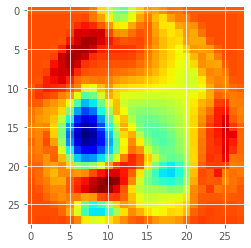

In [56]:
predictions = model.predict(X)
predicted_class = np.argmax(predictions, axis=1)
X_1 = X[predicted_class == 1]
X_0 = X[predicted_class == 0]
cam, heatmap = grad_cam(model, X_1, 1)
plt.figure(figsize=(4,4))
plt.imshow(cam, cmap='jet')
plt.show()

## Visualize CAMs

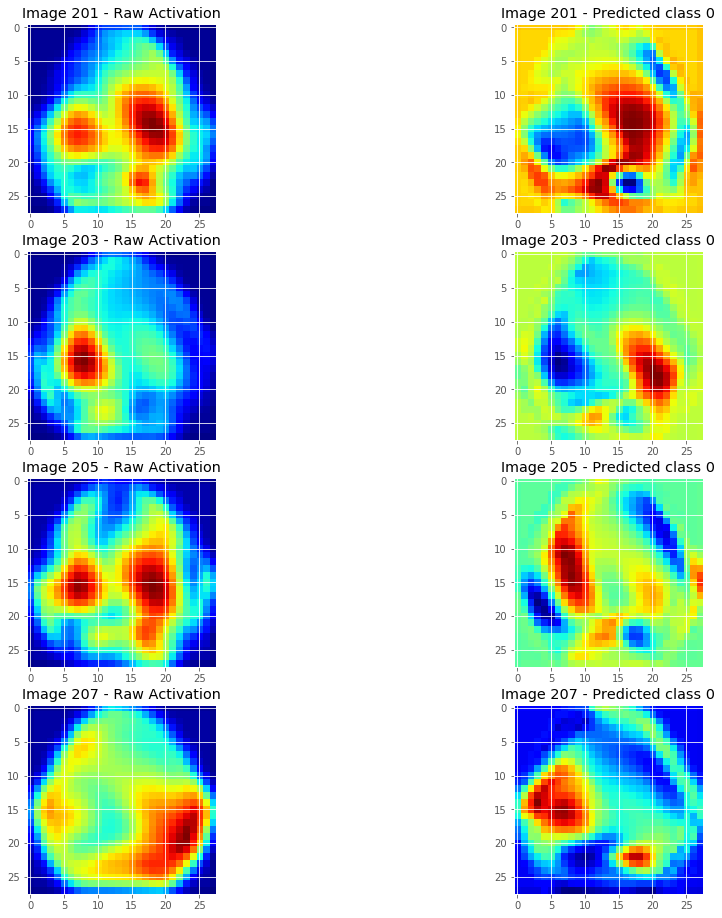

In [62]:
    
fig= plt.figure(figsize=(16, 16))
columns = 2
rows = 4
offset = 200
for i in range(1, columns * rows + 1, columns):
    #cam0, heatmap0 = grad_cam(model, X[i], 0, 'conv2d_2')
    #fig.add_subplot(rows, columns, i)
    #plt.imshow(cam0, cmap='jet')
    #plt.title(f'Image {i} - class {0}')
    j = i + offset
    cam_n, heatmap_n = naive_cam(model, X[j][None])
    fig.add_subplot(rows, columns, i)
    plt.imshow(cam_n, cmap='jet')
    plt.title(f'Image {j} - Raw Activation')
    
    predicted_class = np.argmax(predictions[j])
    
    cam1, heatmap1 = grad_cam(model, X[j][None], predicted_class)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(cam1, cmap='jet')
    plt.title(f'Image {j} - Predicted class {predicted_class}')
    
plt.show()